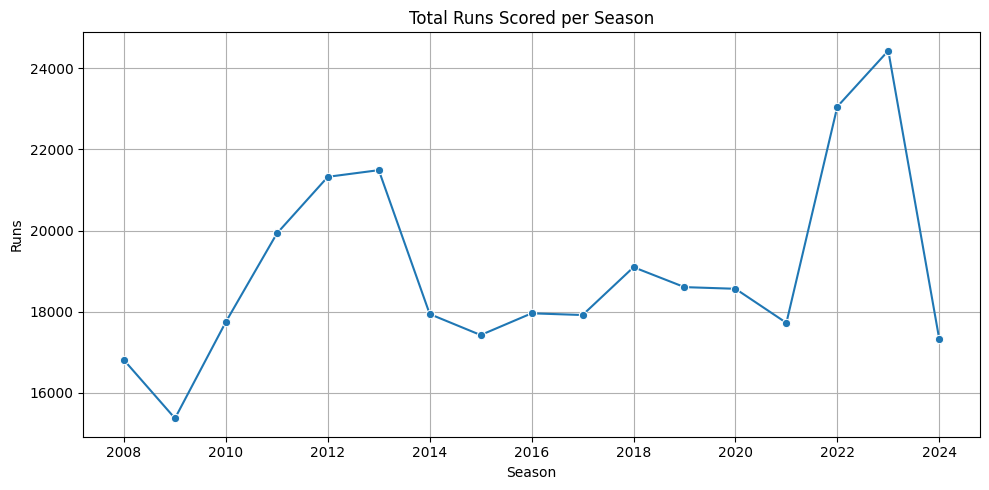

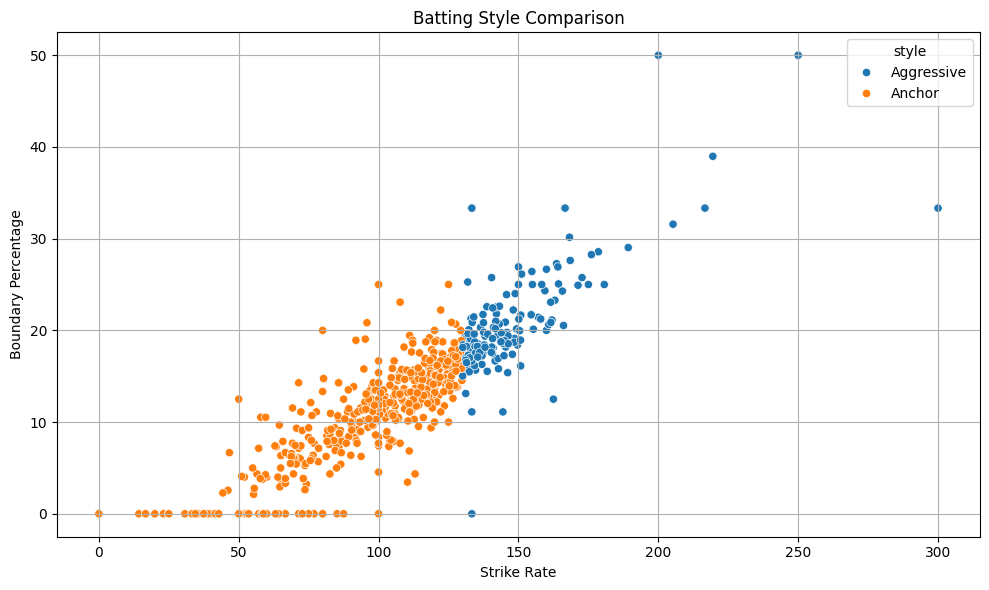

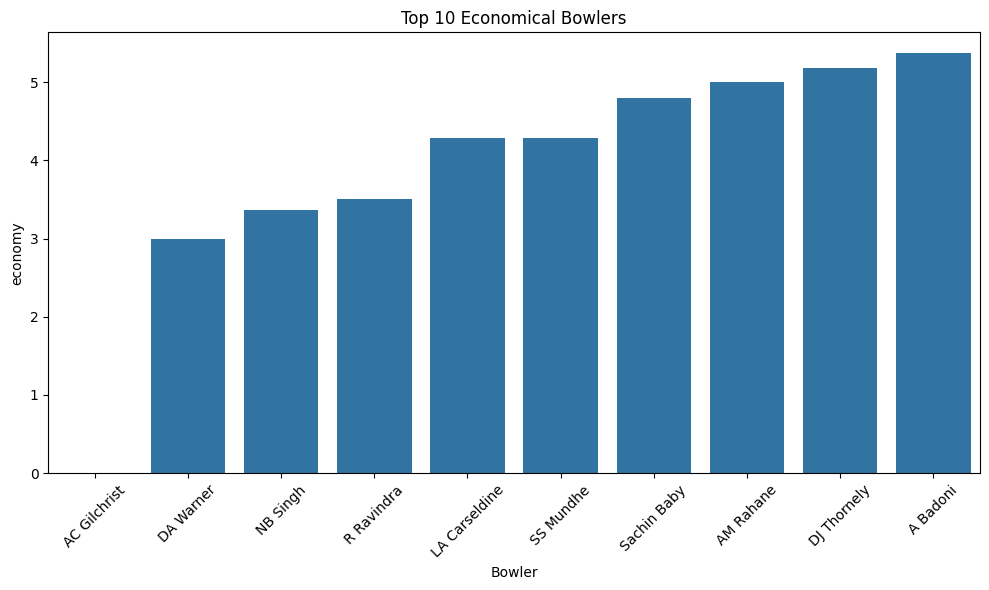

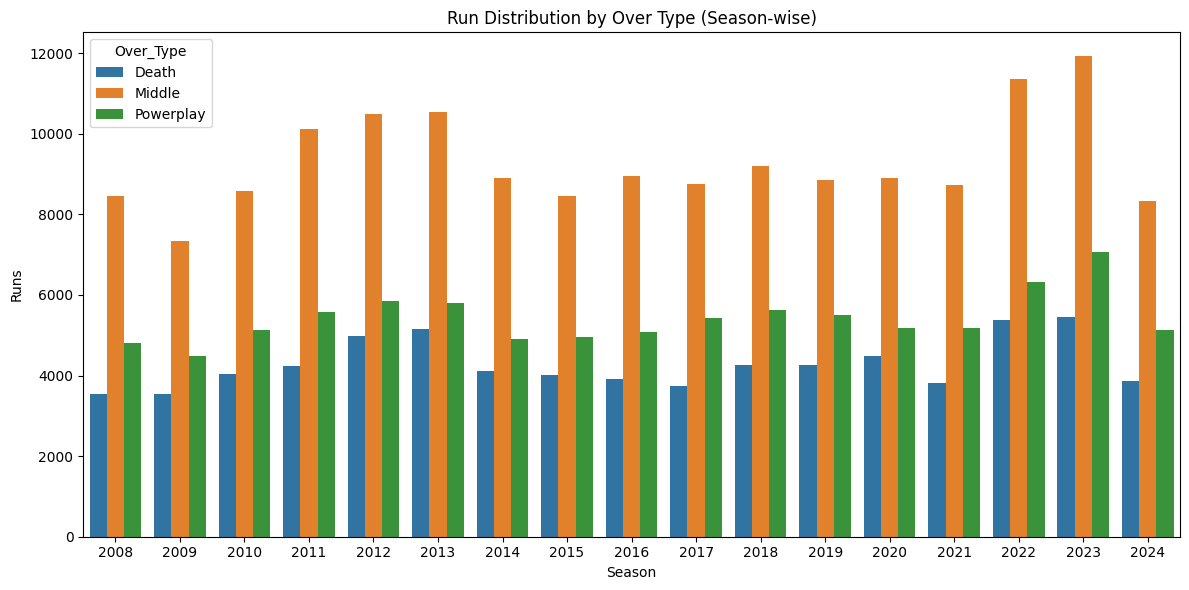

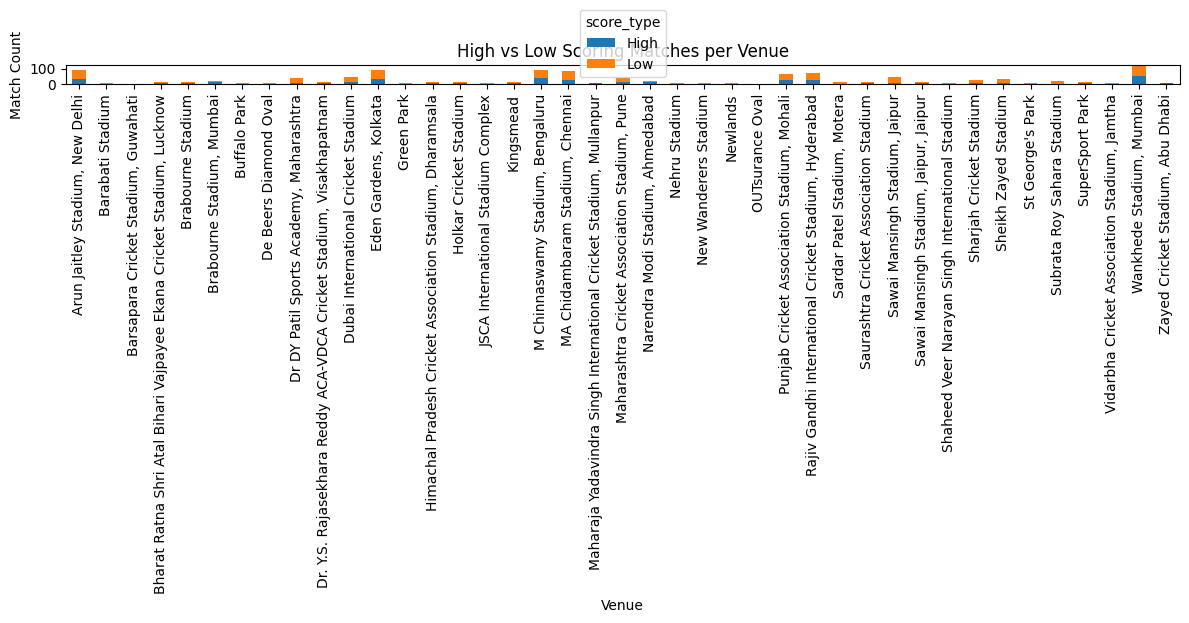

✅ Match Winner Predictor Accuracy: 0.11


In [1]:
# 🏏 IPL Full Analysis - Jupyter Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Load datasets
# 📥 Load datasets

try:
    ball_by_ball_df = pd.read_csv('D:/cohort/Capstone Project/IPL/IPL Dataset/IPL_Ball_By_Ball.csv')
    teams_info_df = pd.read_csv('D:/cohort/Capstone Project/IPL/IPL Dataset/ipl_teams_2024_info.csv')
    players_info_df = pd.read_csv('D:/cohort/Capstone Project/IPL/IPL Dataset/Players_Info_2024.csv')
    team_performance_df = pd.read_csv('D:/cohort/Capstone Project/IPL/IPL Dataset/Team_Performance.csv')
except FileNotFoundError as e:
    print(f"❌ Error loading dataset: {e}")
    raise


# Clean column names
for df in [ball_by_ball_df, teams_info_df, players_info_df, team_performance_df]:
    df.columns = df.columns.str.strip().str.replace(" ", "_")

# Merge player info into ball-by-ball data
ball_merged = ball_by_ball_df.merge(
    players_info_df[['Player_Name', 'Player_Role', 'Batting_Style', 'Bowling_Style']],
    left_on='Striker', right_on='Player_Name', how='left'
)

# ----------------------------------------
# 📈 Run Trends Over the Years
# ----------------------------------------
runs_per_season = ball_merged.groupby('Season')['runs_scored'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=runs_per_season, x='Season', y='runs_scored', marker='o')
plt.title("Total Runs Scored per Season")
plt.xlabel("Season")
plt.ylabel("Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 🧬 Batting Style: Anchor vs Aggressive
# ----------------------------------------
batting_stats = ball_merged.groupby('Striker').agg(
    balls_faced=('Ball_No', 'count'),
    runs=('runs_scored', 'sum'),
    fours=('runs_scored', lambda x: (x == 4).sum()),
    sixes=('runs_scored', lambda x: (x == 6).sum())
).reset_index()
batting_stats['strike_rate'] = batting_stats['runs'] / batting_stats['balls_faced'] * 100
batting_stats['boundary_pct'] = (batting_stats['fours'] + batting_stats['sixes']) / batting_stats['balls_faced'] * 100
batting_stats['style'] = batting_stats['strike_rate'].apply(lambda x: 'Aggressive' if x > 130 else 'Anchor')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=batting_stats, x='strike_rate', y='boundary_pct', hue='style')
plt.title("Batting Style Comparison")
plt.xlabel("Strike Rate")
plt.ylabel("Boundary Percentage")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# 🎯 Bowling Consistency
# ----------------------------------------
dot_balls = ball_merged[ball_merged['runs_scored'] == 0]
bowling_stats = ball_merged.groupby('Bowler').agg(
    runs_conceded=('runs_scored', 'sum'),
    balls_bowled=('Ball_No', 'count'),
    wickets=('wicket_confirmation', 'sum')
).reset_index()
bowling_stats['dot_balls'] = dot_balls.groupby('Bowler')['Ball_No'].count().reindex(bowling_stats['Bowler'], fill_value=0)
bowling_stats['economy'] = bowling_stats['runs_conceded'] / (bowling_stats['balls_bowled'] / 6)
bowling_stats['average'] = bowling_stats['runs_conceded'] / bowling_stats['wickets'].replace(0, 1)
top_bowlers = bowling_stats.sort_values(by='economy').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_bowlers, x='Bowler', y='economy')
plt.title("Top 10 Economical Bowlers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------------------
# ⏱️ Run Distribution by Over Type
# ----------------------------------------
def classify_over(ball):
    over = int(float(ball))
    if over < 6:
        return 'Powerplay'
    elif over >= 16:
        return 'Death'
    else:
        return 'Middle'

ball_merged['Over_Type'] = ball_merged['Ball_No'].apply(classify_over)
overs_perf = ball_merged.groupby(['Season', 'Over_Type'])['runs_scored'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=overs_perf, x='Season', y='runs_scored', hue='Over_Type')
plt.title("Run Distribution by Over Type (Season-wise)")
plt.ylabel("Runs")
plt.tight_layout()
plt.show()

# ----------------------------------------
# 🏟️ Venue Behavior: High vs Low Scoring
# ----------------------------------------
team_performance_df['total_score'] = team_performance_df['First_Innings_Score'] + team_performance_df['Second_Innings_Score']
team_performance_df['score_type'] = team_performance_df['total_score'].apply(lambda x: 'High' if x > 340 else 'Low')
venue_score = team_performance_df.groupby(['Venue', 'score_type']).size().unstack().fillna(0)

venue_score.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("High vs Low Scoring Matches per Venue")
plt.ylabel("Match Count")
plt.tight_layout()
plt.show()

# ----------------------------------------
# 🤖 Match Winner Predictor (Simple Model)
# ----------------------------------------
model_data = team_performance_df[['First_Innings_Score', 'Second_Innings_Score', 'Match_Winner']].dropna()
features = model_data[['First_Innings_Score', 'Second_Innings_Score']]
labels = model_data['Match_Winner']
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"✅ Match Winner Predictor Accuracy: {accuracy:.2f}")
